In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(ggplot2)

# Group proposal on developing predictive model in detecting and preventing forest fires in the Algerian regions.

In the Algerian regions(Northern Africa) of **Bejaia** and **Sidi Bel-abbes** during the period, between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. 
Our project aims to construct a prediction model for forest fires and we will use the Algerian Forest Fires Dataset, which contains data from two sub-regions.

**Brief explanation**
* Temperature: Degree Celsius
* RH: Relative Humidity (%)
* Ws: Wind speed (km/h)
* ISI (Initial Spread Index): estimation of the anticipated spread of a fire that is based on FFMC. 
* FFMC (fine fuel moisture code): the moisture content based on litter or other fine fuels. 
* DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest.
* BUI (Buildup Index): the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 
* FWI (Fire Weather Index): the rating of the strength of the fire.



In [28]:
B_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                slice(1:124)%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')
head(B_forestfire_data)

S_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 126, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')
head(S_forestfire_data)

Warning message:
“16 parsing failures.
row         col   expected      actual                                                                                                       file
123 day         a number   -           'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..............................................

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,June,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,June,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,June,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
5,June,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
6,June,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
 44 FWI a number   fire       'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
 44 NA  14 columns 13 columns 'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,June,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
2,June,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
3,June,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
4,June,2012,30,64,14,0.0,79.4,5.2,15.4,2.2,5.6,1.0,not fire
5,June,2012,32,60,14,0.2,77.1,6.0,17.6,1.8,6.5,0.9,not fire
6,June,2012,35,54,11,0.1,83.7,8.4,26.3,3.1,9.3,3.1,fire


**To tidy the dataset, we gave appropriate column types for the variables, the ‘Classes’ column was filtered out due to some rows of NA data.**

In [29]:
#1
nrow(S_forestfire_data) + nrow(B_forestfire_data)

[1] 243

**Exploratory Steps**

Firstly,this is a small dataset and we decided to slice the data with 76% for the training set and 24% for the testing set. This will ensure that the training set is large enough while still having sufficient data for the testing set to test the accuracy

We explored the data to see their sizes and the count under each class. We made tables and plots of FWI values evaluating whether a fire class always has a greater FWI value than a non-fire class in two subregions.

We'll use different variables to create plots to visualize the relationships between the vectors.


In [30]:
set.seed(100)

B_forest_split <- initial_split(B_forestfire_data, prop = 0.76, strata = Classes)
S_forest_split <- initial_split(S_forestfire_data, prop = 0.76, strata = Classes)

B_training <- training(B_forest_split)
B_testing <- testing(B_forest_split)

S_training <- training(S_forest_split)
S_testing <- testing(S_forest_split)

`summarise()` regrouping output by 'month' (override with `.groups` argument)

`summarise()` regrouping output by 'month' (override with `.groups` argument)



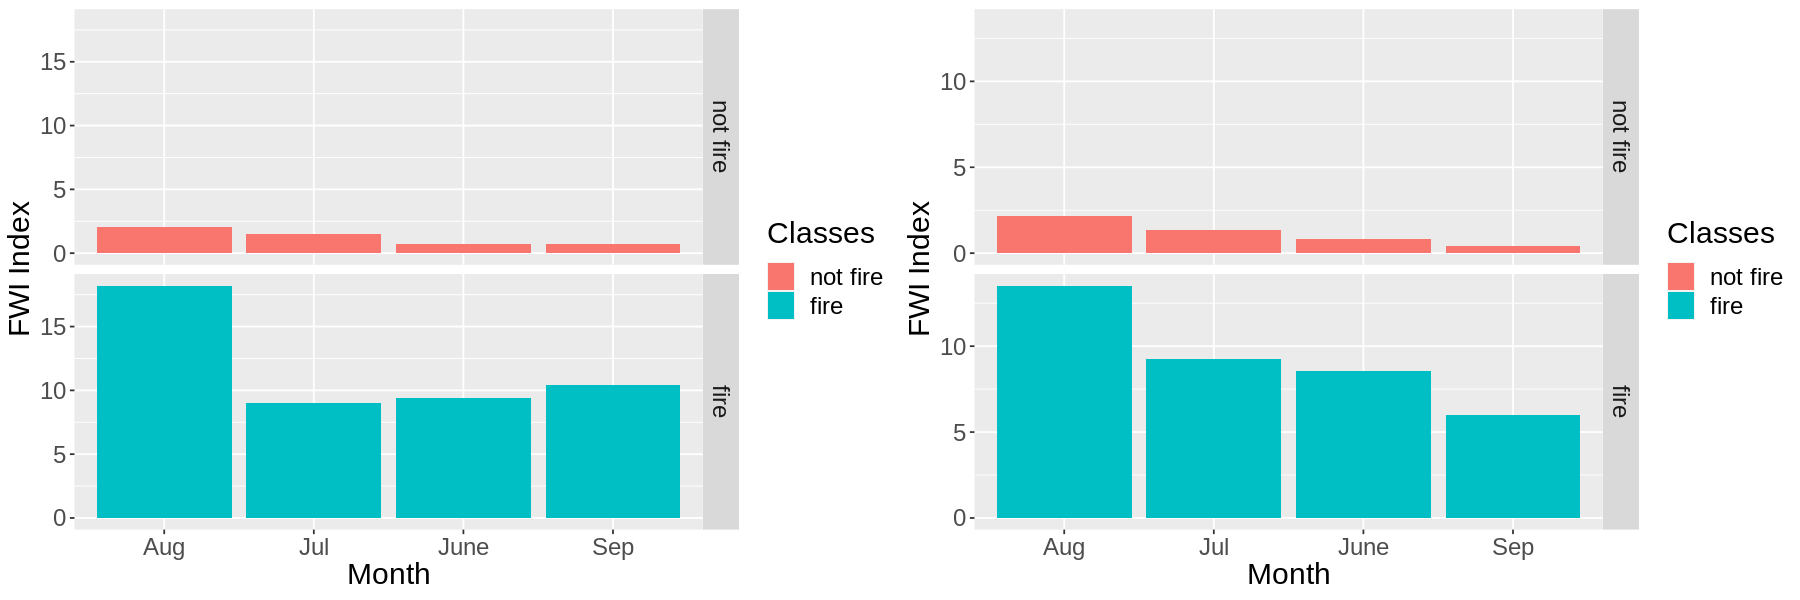

In [31]:

S_FWI <- S_training %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)

S_FWI_plot <- S_FWI %>%
                    ggplot(aes(x = month, y = FWI, fill = Classes))+
                    geom_bar(stat = "identity")+
                    facet_grid(Classes~.)+
                    labs(x = "Month", y = "FWI Index", fill = "Classes")+
                    theme(text = element_text(size = 18))


B_FWI <- B_training %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)

B_FWI_plot <- B_FWI %>%
                    ggplot(aes(x = month, y = FWI, fill = Classes))+
                    geom_bar(stat = "identity")+
                    facet_grid(Classes~.)+
                    labs(x = "Month", y = "FWI Index", fill = "Classes")+
                    theme(text = element_text(size = 18))

options(repr.plot.width = 15, repr.plot.height = 5)
plot_grid(S_FWI_plot,B_FWI_plot, ncol = 2)
            

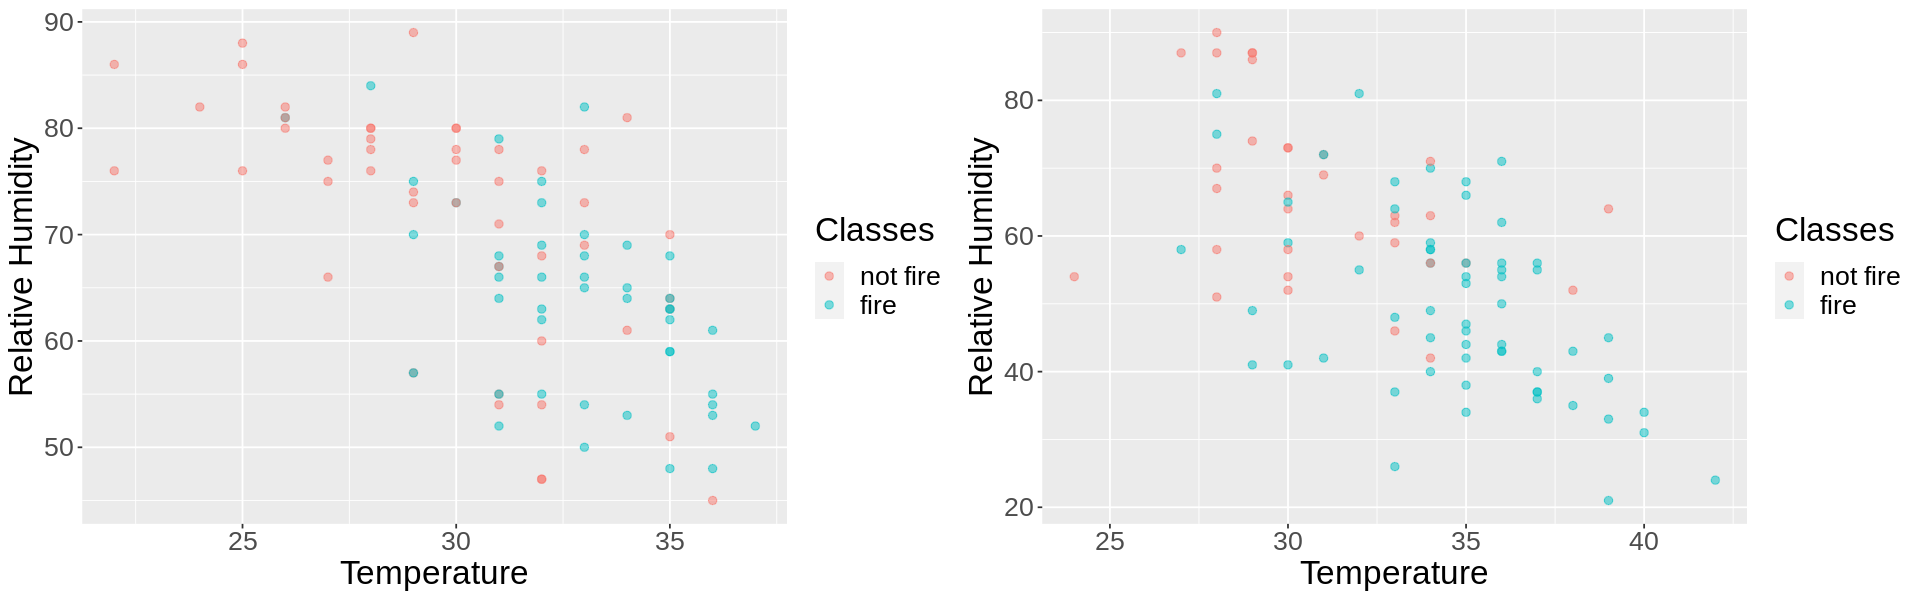

In [32]:
options(repr.plot.width = 16, repr.plot.height = 5)

temp_ws <- B_training %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

s_temp_ws <- S_training %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

plot_grid(temp_ws,s_temp_ws, ncol = 2)

**Both plots showed a negative moderately strong linear relationship. Fires become more likely to occur as temperatures increase and relative humidity decreases.Fires predominantly occur when temperatures are above thirty degrees Celsius and relative humidity is less than 70.**

**From these plots, we realized the dataset needs to be scaled and centred.**

In [33]:
SB_training <- B_training %>%
                        mutate(Temperature = scale(Temperature, center = TRUE),
                              RH = scale(RH, center = TRUE),
                              Ws = scale(Ws, center = TRUE),
                              Rain = scale(Rain, center = TRUE))

SS_training <- S_training %>%
                        mutate(Temperature = scale(Temperature, center = TRUE),
                              RH = scale(RH, center = TRUE),
                              Ws = scale(Ws, center = TRUE),
                              Rain = scale(Rain, center = TRUE))



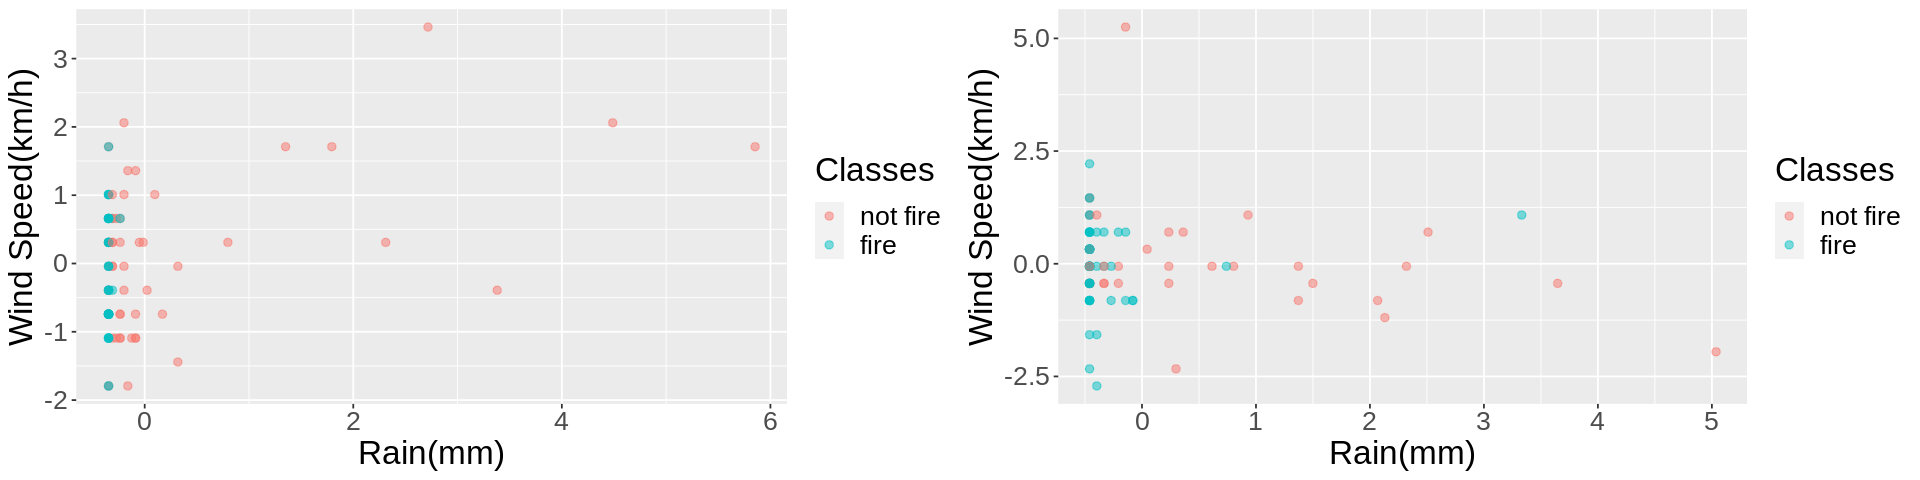

In [34]:
options(repr.plot.width = 16, repr.plot.height = 4)
#checking scaled data in plots

b_rain_ws <- SB_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))

s_rain_ws <- SS_training %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
plot_grid(b_rain_ws,s_rain_ws, ncol = 2)

**Methods**

* Further tuning the classifiers using cross-validation with C = 5, which would prevent the data from under fitting or overfitting, and each observation will only be used once in a validation set.
* Picking a K value by visualizing the Accuracy Estimation vs. Number of Neighbours for the classification models.
* Developing two models: one with only FWI as predictor and the other with four vectors from column Temperature to column Rain. Testing and comparing their accuracies on testing datasets.


**Expected outcomes and significance**

We expect to find that the model could predict future forest fires with an accuracy above 82%. This result can be applied to proactive methods to prevent and detect fire signals. 

We can think of further inquiries such as, does the model fit for other regions in this country, and what about other countries?


**Creating Recipes and Specification**


In [75]:
#models and recipes for both regions. 
set.seed(100)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

#FWI recipe
B_fires_recipe_FWI <- recipe(Classes ~ FWI, data = B_training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

S_fires_recipe_FWI <- recipe(Classes ~ FWI, data = S_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Four vectors recipe
B_fires_recipe_2 <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = B_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

S_fires_recipe_2 <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = S_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())


**Cross-Validation for two datasets**

In [76]:
set.seed(100)

B_vfold <- vfold_cv(B_training, v = 5, strata = Classes)

S_vfold <- vfold_cv(S_training, v = 5, strata = Classes)

**Workflow analysis with recipes and models while trying for 10 values of $k$**

In [77]:
set.seed(100)
#FWI recipe
knn_results_B_FWI<- workflow() %>%
    add_recipe(B_fires_recipe_FWI)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = B_vfold, grid= 10)%>%
    collect_metrics()

knn_results_S_FWI<- workflow() %>%
    add_recipe(S_fires_recipe_FWI)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = S_vfold, grid= 10)%>%
    collect_metrics()

#Four vectors recipe
knn_results_B_2 <- workflow() %>%
    add_recipe(B_fires_recipe_2)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = B_vfold, grid= 10)%>%
    collect_metrics()

knn_results_S_2 <- workflow() %>%
    add_recipe(S_fires_recipe_2)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = S_vfold, grid= 10)%>%
    collect_metrics()


! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



In [78]:
accuracies_B_FWI <- knn_results_B_FWI %>%
                 filter(.metric == 'accuracy')

accuracies_S_FWI <- knn_results_S_FWI %>%
                filter(.metric == 'accuracy')

accuracies_B_2 <-knn_results_B_2 %>%
                filter(.metric == 'accuracy')

accuracies_S_2 <- knn_results_S_2 %>%
                filter(.metric == 'accuracy')


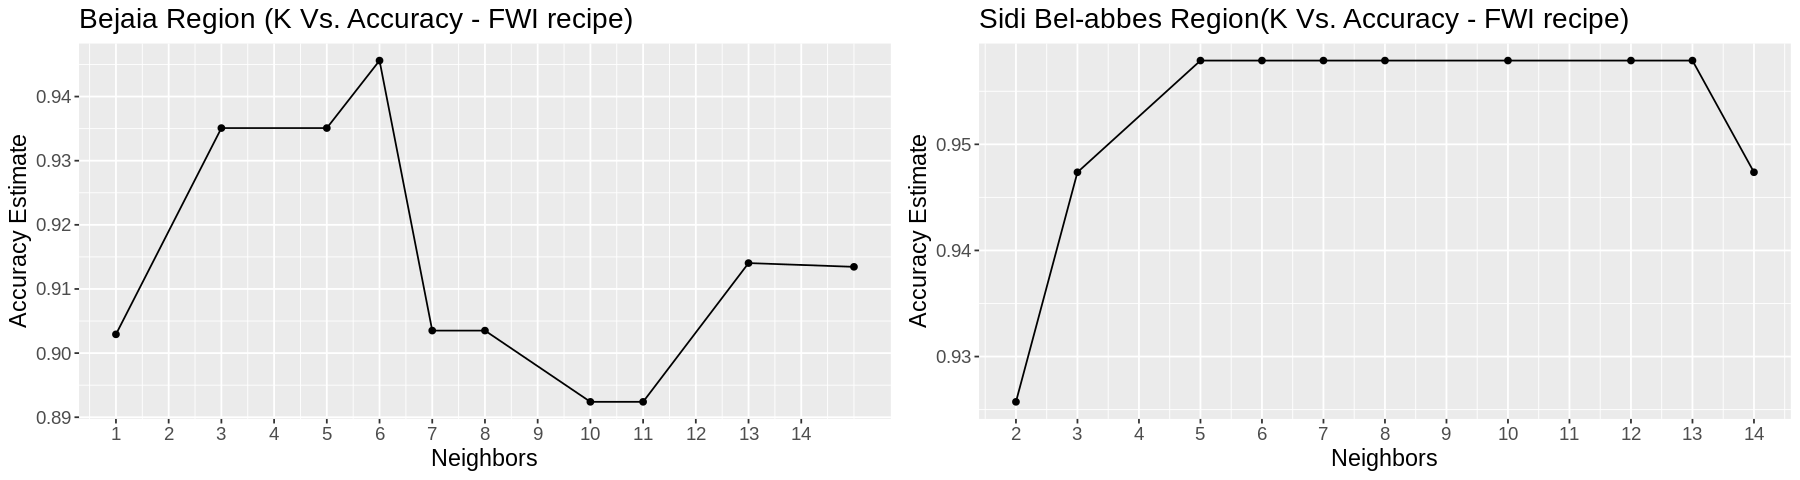

In [79]:
options(repr.plot.width = 15, repr.plot.height = 4)
#K Vs. Accuracy plots for both region(FWI recipe)
B_FWI_K <- ggplot(accuracies_B_FWI, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("Bejaia Region (K Vs. Accuracy - FWI recipe)")

S_FWI_K <- ggplot(accuracies_S_FWI, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("Sidi Bel-abbes Region(K Vs. Accuracy - FWI recipe)")

plot_grid(B_FWI_K,S_FWI_K, ncol = 2)

**We would like to choose K = 6 for both Bejaia Region and Sidi Bel-abbes Region, because K = 6 has the highest accuracy from both plots while it is not a huge number for computation.**

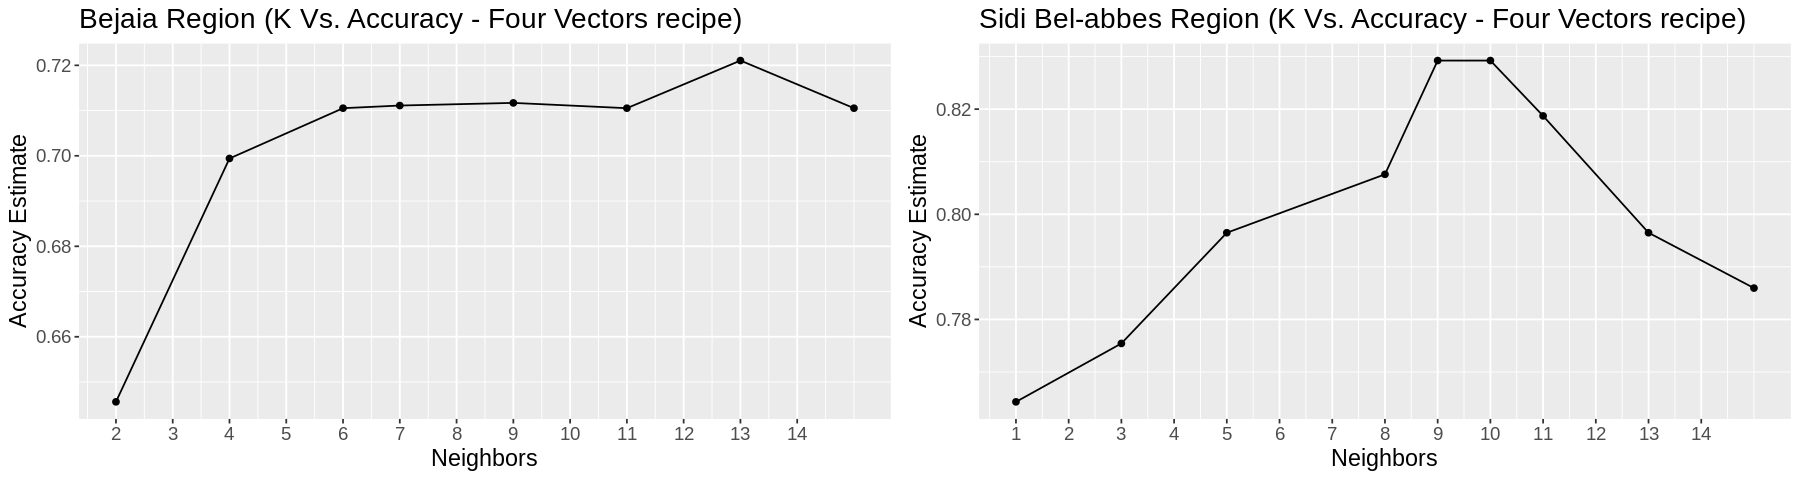

In [80]:
#K Vs. Accuracy plots for both region(Four vectors recipe)
options(repr.plot.width = 15, repr.plot.height = 4)

B_2_K <- ggplot(accuracies_B_2, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("Bejaia Region (K Vs. Accuracy - Four Vectors recipe)")


S_2_K <- ggplot(accuracies_S_2, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("Sidi Bel-abbes Region (K Vs. Accuracy - Four Vectors recipe)")

plot_grid(B_2_K,S_2_K, ncol = 2)

**Best K values from the two plots above:**
* K = 13 for Bejaia Region (with Four vector recipe)
* K = 9 for Sidi Bel-abbes Region (with Four vector recipe)


In [81]:
FWI_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
        set_engine("kknn")%>%
        set_mode("classification")

b_4v_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13)%>%
        set_engine("kknn")%>%
        set_mode("classification")

s_4v_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9)%>%
        set_engine("kknn")%>%
        set_mode("classification")

In [82]:
#Bejaia Region
b_FWI_fit <- workflow()%>%
        add_recipe(B_fires_recipe_FWI)%>%
        add_model(FWI_spec)%>%
        fit(data = B_training)

b_4v_fit <- workflow()%>%
        add_recipe(B_fires_recipe_2)%>%
        add_model(b_4v_spec)%>%
        fit(data = B_training)


#Sidi Bel-abbes Region
s_FWI_fit <- workflow()%>%
        add_recipe(S_fires_recipe_FWI)%>%
        add_model(FWI_spec)%>%
        fit(data = S_training)

s_4v_fit <- workflow()%>%
        add_recipe(S_fires_recipe_2)%>%
        add_model(s_4v_spec)%>%
        fit(data = S_training)


In [83]:
#Bejaia Region
b_f_prediction <- predict(b_FWI_fit, B_testing)%>%
        bind_cols(B_testing)

b_4v_prediction <- predict(b_4v_fit, B_testing)%>%
        bind_cols(B_testing)


#Sidi Bel-abbes Region
s_f_prediction <- predict(s_FWI_fit, S_testing)%>%
        bind_cols(S_testing)

s_4v_prediction <- predict(s_4v_fit, S_testing)%>%
        bind_cols(S_testing)


head(b_f_prediction, 3)

.pred_class,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,2,June,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
not fire,4,June,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
not fire,10,June,2012,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire


In [85]:
#Bejaia Region
b_f_metrics <- b_f_prediction %>%
            metrics(truth = Classes, estimate = .pred_class)
b_f_metrics


b_4v_metrics <- b_4v_prediction %>%
        metrics(truth = Classes, estimate = .pred_class)
b_4v_metrics


#Sidi Bel-abbes Region
s_f_metrics <- s_f_prediction %>%
        metrics(truth = Classes, estimate = .pred_class)
s_f_metrics


s_4v_metrics <- s_4v_prediction %>%
            metrics(truth = Classes, estimate = .pred_class)
s_4v_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9655172
kap,multiclass,0.9307876


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7241379
kap,multiclass,0.4502370


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9642857
kap,binary,0.9204545


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7857143
kap,binary,0.5531915
